In [14]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import sklearn.linear_model
import os
import sklearn

# 3.1 MNIST


In [4]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [6]:
X,y= mnist["data"], mnist['target']
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

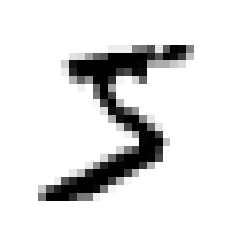

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis("off")
plt.show()

In [9]:
y[0]

'5'

In [10]:
# 레이블이 문자열이므로 정수로 변환 (알고리즘 상 정수로 해야함)
y=y.astype(np.uint8)

In [11]:
# 총 70000개중 mnist는 60000개를  train, 10000개를 test 으로 지정되어 있음

X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

# 훈련 데이터 셋은 이미 섞여있어서 모든 교차 검증 폴드를 비슷하게 만듭니다.
# -> 비슷한 샘플이 연이어 나타나거나(특정 알고리즘의 경우) 하나의 폴드라도 특정 숫자가 누락되면 선은이 나빠집니다.
# -> 데이터셋을 섞으면 이런 문제를 방지할 수 있습니다! (다만 시계열 데이터를 다룰떄는 섞는것이 대체로 좋지 않습니다.)

#####
# SGDclassifier, SGDRegressor 는 기본적으로 에폭마다 데이터를 다시 섞습니다! 


# 3.2 이진 분류기 훈련

In [12]:
y_train_5=(y_train==5)
y_test_5=(y_test==5)

In [18]:
from sklearn.linear_model import SGDClassifier
# SGD는 한번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문에 매우 큰 데이터셋을 효율적으로 처리하는 장점을 가지고 있습니다.


sgd_clf=SGDClassifier(random_state =42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
sgd_clf.predict([some_digit])# 5를 나타낸다고 올바르게 추측!

array([ True])

# 3.3 성능 측정

In [21]:
from sklearn.model_selection import StratifiedKFold # StratifiedKFold : 클래스별 비율이 유지되도록 계층적 샘플링
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf= clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred =clone_clf.predict(X_test_fold)
    n_correct =sum(y_pred ==y_test_fold)
    print(n_correct/len(y_pred))

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [23]:
from sklearn.model_selection import cross_val_score # 각 테스트 폴드에서 얻은 점수를 반환
cross_val_score(sgd_clf, X_train, y_train,cv=3,scoring="accuracy") # 3fold 사용

array([0.87365, 0.85835, 0.8689 ])

In [24]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)
# 모든 이미지를 5 아님 이라고 분류하는 더미 클래스 

In [25]:
never_5_clf =Never5Classifier()

cross_val_score(never_5_clf, X_train,y_train,cv=3, scoring ="accuracy")

# 5가 아닌 것이 90% 가량 되기떄문에 모두 5가 아니라고 하면 정확도가 90% 가량 나옴 
# -> imblanced data에 특히 적절하지 못함

array([0.0997 , 0.0965 , 0.09995])

# 3.3.2 오차 행렬

In [35]:
from sklearn.model_selection import cross_val_predict

y_train_pred =cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# cross_val_predict -> 각 테스트 폴드에서 얻은 예측갑을 반환 

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [ ]:
precision= TP/ (TP+FP) 정밀도 : 실제 양성인것 중 분류기가 양성으로 분류한 것의 비율
recall = TP/ (TP+FN) 재현율 = 민감도 : 분류기가 양성으로 분류한 것 중 실제 양성의 비율
        T    F  (예) 
     T  TP   FN
(실)  
     F  FP   TN 

# 3.3.3 정밀도와 재현율

In [37]:
from sklearn.metrics import precision_score, recall_score 
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [38]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [ ]:
F_score: 정밀도와 재현율의 조화평균 
         = 2/ (1/정밀도 + 1/재현율)

In [39]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred) # 정밀도와 재현율이 비슷한 분류기에서는 F1점수가 높음 
# -> 태스크에 따라 다르게 측정해야함


0.7325171197343846

In [ ]:
어린아이에게 안전한 동영상을 걸러내는 분류기 훈련

재현율이 높음, 정밀도 낮음 -> 정말 나쁜 동영상 몇개 노출, 좋은 동영상 다수 노출
재현률이 낮음, 정밀도 높음 -> 나쁜 동영상 노출 안함, 좋은 동영상 많이 제외

정밀도, 재현율에 트레이드 오프가 있으므로 태스크에 따라 판단해야함

# 3.3.4 정밀도/재현율 트레이드 오프

In [40]:
y_scores =sgd_clf.decision_function([some_digit]) 
y_scores# sgd는 예측에 사용한 점수를 확인할 수 있습니다 이 점수를 기반으로 원하는 임계값을 정해서 분류기를 만들 수 있습니다.

array([2164.22030239])

In [42]:
threshold=0
y_some_digit_pred= (y_scores > threshold)
y_some_digit_pred

array([ True])

In [43]:
threshold=8000
y_some_digit_pred= (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
# 임계값에 따라 재현율, 정밀도가 달라진다-> 재현율에 대한 정밀도 곡선을 그려서 판단한다 

In [64]:
y_scores = cross_val_predict(sgd_clf,X_train, y_train_5, cv=3, method = "decision_function"  )# 훈련세트의 모든 점수 취합

In [65]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


In [74]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1],"g--",label="재현율")


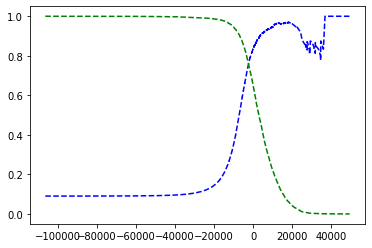

In [75]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()# 임계값이 올라가도 정밀도가 낮아질때가 가끔 있습니다 (일반적으로는 높아져애 합니다) 

In [69]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [70]:
y_train_pred_90=(y_scores >= threshold_90_precision)

In [71]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [72]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# 3.3.5 ROC 곡선

In [76]:
from sklearn.metrics import roc_curve

fpr,tpr, thresholds = roc_curve(y_train_5, y_scores)

In [77]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr, label=label)

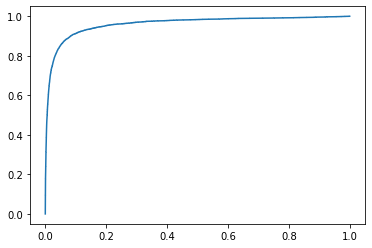

In [78]:
plot_roc_curve(fpr,tpr) # 대각선은 랜덤분류 

In [79]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores) # auc 계산

0.9604938554008616

In [80]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_forest=cross_val_predict(forest_clf ,X_train,y_train_5,cv=3,method="predict_proba")

In [83]:
y_score_forest =y_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_score_forest) 


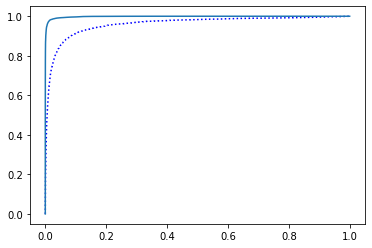

In [86]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest, "랜덤 포레스트")
# 랜포가 더 좋음 

# 3.6 다중 레이블 분류

In [ ]:
데이터 에 다중 레이블이 있는 것의 분류(사람 얼굴 여러개 등)

In [88]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7) # 7보다 크거나 작은지
y_train_odd=(y_train%2==1) # 홀수인지
y_multilabel=np.c_[y_train_large,y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [89]:
knn_clf.predict([some_digit]) # some_digit은 5이므로 둘다 맞음 ! 

array([[False,  True]])

In [ ]:
y_train_knn_pred=cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
f1_score(y_multilabel, y_train_knn_pred,average= "macro")# average="weighted"로  클래스마다 가중치를 줄 수도 있음
# 모든 레이블의 f1스코어의 평균을 계산함

# 3.7 다중 출력 분류 

잡음이 많은 숫자를 입력받고  깨끗한 숫자이미지를 출력합니다 (다중 레이블(픽셀당 한레이블), 레이블이 값을 여러개 가짐(0~255))

In [ ]:
noise = np.random.randint(0,100,len(X_train),784))
X_train_mod=X_train+noise
noise = np.random.randint(0,100,len(X_test),784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test


In [ ]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)